# Installing Packages

In [0]:
!pip install --no-cache-dir torch-tensornet torchsummary==1.5.1

# Imports
Importing necessary packages and modules

In [0]:
%matplotlib inline

import random
import matplotlib.pyplot as plt

from torchsummary import summary

from tensornet import train, evaluate
from tensornet.data import CIFAR10
from tensornet.model import ResNet18
from tensornet.model.utils.loss import cross_entropy_loss
from tensornet.model.utils.optimizers import sgd
from tensornet.model.utils.callbacks import step_lr
from tensornet.gradcam import GradCAMView
from tensornet.utils import initialize_cuda, class_level_accuracy, plot_metric, save_and_show_result

# Configuration

Set various parameters and hyperparameters

In [0]:
class Args:

    # Data Loading
    # ============

    train_batch_size = 64
    val_batch_size = 64
    num_workers = 4

    # Augmentation
    # ============
    horizontal_flip_prob = 0.2
    rotate_degree = 20
    cutout = 0.3

    # Training
    # ========
    random_seed = 1
    epochs = 30
    learning_rate = 0.01
    momentum = 0.9
    lr_step_size = 25
    lr_gamma = 0.1

    # Evaluation
    # ==========
    sample_count = 25

## Set Seed and Get GPU Availability

In [0]:
# Initialize CUDA and set random seed
cuda, device = initialize_cuda(Args.random_seed)

GPU Available? True


## Download Dataset

Importing the CIFAR-10 class to download dataset and create data loader

In [0]:
dataset = CIFAR10(
    train_batch_size=Args.train_batch_size,
    val_batch_size=Args.val_batch_size,
    cuda=cuda,
    num_workers=Args.num_workers,
    horizontal_flip_prob=Args.horizontal_flip_prob,
    rotate_degree=Args.rotate_degree,
    cutout=Args.cutout
)

Extracting /usr/local/lib/python3.6/dist-packages/tensornet/data/cifar10/cifar-10-python.tar.gz to /usr/local/lib/python3.6/dist-packages/tensornet/data/cifar10
Files already downloaded and verified
Files already downloaded and verified


## Data Visualization
Let's see how our data looks like. This information will help us decide the transformations that can be used on the dataset.

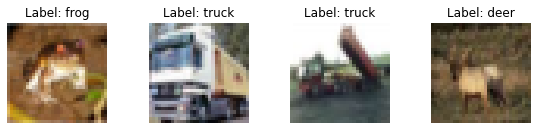

In [0]:
# Fetch data
classes = dataset.classes
sample_data, sample_targets = dataset.data()

# Set number of images to display
num_images = 4

# Display images with labels
fig, axs = plt.subplots(1, 4, figsize=(8, 8))
fig.tight_layout()

for i in range(num_images):
    axs[i].axis('off')
    axs[i].set_title(f'Label: {classes[sample_targets[i]]}')
    axs[i].imshow(sample_data[i])

## Training and Validation Dataloaders
This is the final step in data preparation. It sets the dataloader arguments and then creates the dataloader

In [0]:
# Create train data loader
train_loader = dataset.loader(train=True)

# Create val data loader
val_loader = dataset.loader(train=False)

# Model Architecture and Summary

In [0]:
model = ResNet18().to(device)  # Create model
summary(model, dataset.image_size)  # Display model summary

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
        BasicBlock-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchNorm2d-11           [-1, 64, 32, 32]             128
       BasicBlock-12           [-1, 64, 32, 32]               0
           Conv2d-13          [-1, 128, 16, 16]          73,728
      BatchNorm2d-14          [-1, 128,

# Model Training and Validation

In [0]:
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []
correct_samples = []
incorrect_samples = []

criterion = cross_entropy_loss()  # Create loss function
optimizer = sgd(model, Args.learning_rate, Args.momentum)  # Create optimizer
scheduler = step_lr(optimizer, Args.lr_step_size, Args.lr_gamma)
last_epoch = False

for epoch in range(1, Args.epochs + 1):
    print(f'Epoch {epoch}:')
    if epoch == Args.epochs:
        last_epoch = True
    train(model, train_loader, device, optimizer, criterion, train_losses, train_accuracies)
    scheduler.step()
    evaluate(
        model, val_loader, device, criterion, val_losses, val_accuracies,
        correct_samples, incorrect_samples, Args.sample_count, last_epoch=last_epoch
    )

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 1:


  0%|          | 0/782 [00:00<?, ?it/s]


Validation set: Average loss: 0.0143, Accuracy: 6743/10000 (67.43%)

Epoch 2:


  0%|          | 0/782 [00:00<?, ?it/s]


Validation set: Average loss: 0.0133, Accuracy: 7030/10000 (70.30%)

Epoch 3:


  0%|          | 0/782 [00:00<?, ?it/s]


Validation set: Average loss: 0.0096, Accuracy: 7881/10000 (78.81%)

Epoch 4:


  0%|          | 0/782 [00:00<?, ?it/s]


Validation set: Average loss: 0.0116, Accuracy: 7553/10000 (75.53%)

Epoch 5:


  0%|          | 0/782 [00:00<?, ?it/s]


Validation set: Average loss: 0.0082, Accuracy: 8209/10000 (82.09%)

Epoch 6:


  0%|          | 0/782 [00:00<?, ?it/s]


Validation set: Average loss: 0.0075, Accuracy: 8446/10000 (84.46%)

Epoch 7:


  0%|          | 0/782 [00:00<?, ?it/s]


Validation set: Average loss: 0.0070, Accuracy: 8526/10000 (85.26%)

Epoch 8:


  0%|          | 0/782 [00:00<?, ?it/s]


Validation set: Average loss: 0.0075, Accuracy: 8428/10000 (84.28%)

Epoch 9:


  0%|          | 0/782 [00:00<?, ?it/s]


Validation set: Average loss: 0.0068, Accuracy: 8587/10000 (85.87%)

Epoch 10:


  0%|          | 0/782 [00:00<?, ?it/s]


Validation set: Average loss: 0.0063, Accuracy: 8688/10000 (86.88%)

Epoch 11:


  0%|          | 0/782 [00:00<?, ?it/s]


Validation set: Average loss: 0.0062, Accuracy: 8722/10000 (87.22%)

Epoch 12:


  0%|          | 0/782 [00:00<?, ?it/s]


Validation set: Average loss: 0.0068, Accuracy: 8618/10000 (86.18%)

Epoch 13:


  0%|          | 0/782 [00:00<?, ?it/s]


Validation set: Average loss: 0.0069, Accuracy: 8643/10000 (86.43%)

Epoch 14:


  0%|          | 0/782 [00:00<?, ?it/s]


Validation set: Average loss: 0.0064, Accuracy: 8749/10000 (87.49%)

Epoch 15:


  0%|          | 0/782 [00:00<?, ?it/s]


Validation set: Average loss: 0.0064, Accuracy: 8736/10000 (87.36%)

Epoch 16:


  0%|          | 0/782 [00:00<?, ?it/s]


Validation set: Average loss: 0.0067, Accuracy: 8715/10000 (87.15%)

Epoch 17:


  0%|          | 0/782 [00:00<?, ?it/s]


Validation set: Average loss: 0.0060, Accuracy: 8843/10000 (88.43%)

Epoch 18:


  0%|          | 0/782 [00:00<?, ?it/s]


Validation set: Average loss: 0.0061, Accuracy: 8840/10000 (88.40%)

Epoch 19:


  0%|          | 0/782 [00:00<?, ?it/s]


Validation set: Average loss: 0.0070, Accuracy: 8783/10000 (87.83%)

Epoch 20:


  0%|          | 0/782 [00:00<?, ?it/s]


Validation set: Average loss: 0.0056, Accuracy: 8956/10000 (89.56%)

Epoch 21:


  0%|          | 0/782 [00:00<?, ?it/s]


Validation set: Average loss: 0.0060, Accuracy: 8903/10000 (89.03%)

Epoch 22:


  0%|          | 0/782 [00:00<?, ?it/s]


Validation set: Average loss: 0.0063, Accuracy: 8846/10000 (88.46%)

Epoch 23:


  0%|          | 0/782 [00:00<?, ?it/s]


Validation set: Average loss: 0.0061, Accuracy: 8874/10000 (88.74%)

Epoch 24:


  0%|          | 0/782 [00:00<?, ?it/s]


Validation set: Average loss: 0.0061, Accuracy: 8938/10000 (89.38%)

Epoch 25:


  0%|          | 0/782 [00:00<?, ?it/s]


Validation set: Average loss: 0.0059, Accuracy: 8934/10000 (89.34%)

Epoch 26:


  0%|          | 0/782 [00:00<?, ?it/s]


Validation set: Average loss: 0.0048, Accuracy: 9077/10000 (90.77%)

Epoch 27:


  0%|          | 0/782 [00:00<?, ?it/s]


Validation set: Average loss: 0.0048, Accuracy: 9113/10000 (91.13%)

Epoch 28:


  0%|          | 0/782 [00:00<?, ?it/s]


Validation set: Average loss: 0.0047, Accuracy: 9113/10000 (91.13%)

Epoch 29:


  0%|          | 0/782 [00:00<?, ?it/s]


Validation set: Average loss: 0.0048, Accuracy: 9135/10000 (91.35%)

Epoch 30:


Loss=0.08 Batch_ID=781 Accuracy=98.24: 100%|██████████| 782/782 [00:33<00:00, 23.40it/s]



Validation set: Average loss: 0.0048, Accuracy: 9138/10000 (91.38%)



## Plotting Results

Plot changes in validation loss

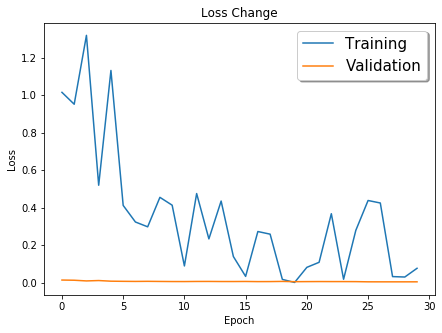

In [0]:
plot_metric(
    {'Training': train_losses, 'Validation': val_losses}, 'Loss'
)

Plot changes in validation accuracy

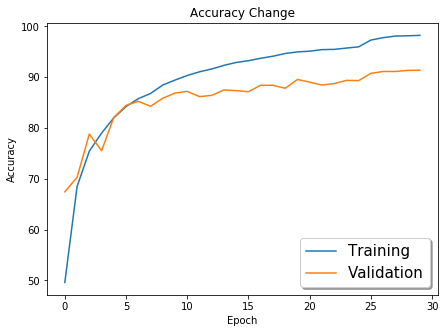

In [0]:
plot_metric(
    {'Training': train_accuracies, 'Validation': val_accuracies}, 'Accuracy'
)

### GradCAM

Let's display GradCAM of any random 2 correctly predicted samples.

In [0]:
def plot_view(layers, view, fig, row_num, ncols, metric):
    """Plot a CAM view.

    Args:
        layers: List of layers
        view: Dictionary containing image, heatmap and result.
        fig: Matplotlib figure instance.
        row_num: Row number of the subplot.
        ncols: Total number of columns in the subplot.
        metric: Can be one of ['heatmap', 'result'].
    """
    sub = fig.add_subplot(row_num, ncols, 1)
    sub.axis('off')
    plt.imshow(view['image'])
    sub.set_title(f'{metric.title()}:')
    for idx, layer in enumerate(layers):
        sub = fig.add_subplot(row_num, ncols, idx + 2)
        sub.axis('off')
        plt.imshow(view[metric][layer])
        sub.set_title(layer)

    
def plot_gradcam(views, layers, plot_path):
    """Plot heatmap and CAM result.

    Args:
        plot_path: Path to save the plot.
        layers: List of layers.
        view: List of dictionaries containing image, heatmap and result.
    """

    for idx, view in enumerate(views):
        # Initialize plot
        fig = plt.figure(figsize=(10, 10))

        # Plot view
        plot_view(layers, view, fig, 1, len(layers) + 1, 'heatmap')
        plot_view(layers, view, fig, 2, len(layers) + 1, 'result')
        
        # Set spacing and display
        fig.tight_layout()
        plt.show()

        # Save image
        fig.savefig(f'{plot_path}_{idx + 1}.png', bbox_inches='tight')

        # Clear cache
        plt.clf()

In [0]:
layers = ['layer1', 'layer2', 'layer3', 'layer4']
grad_cam = GradCAMView(
    model, layers,
    device, dataset.mean, dataset.std
)

images = [x['image'] for x in random.sample(correct_samples, 4)]
gradcam_views = grad_cam(images)

Mode set to GradCAM.


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2416: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


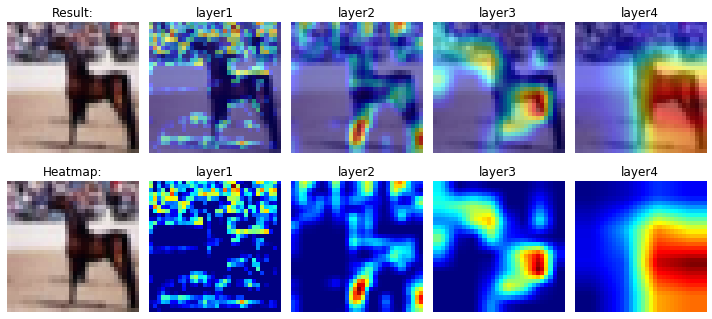

<Figure size 432x288 with 0 Axes>

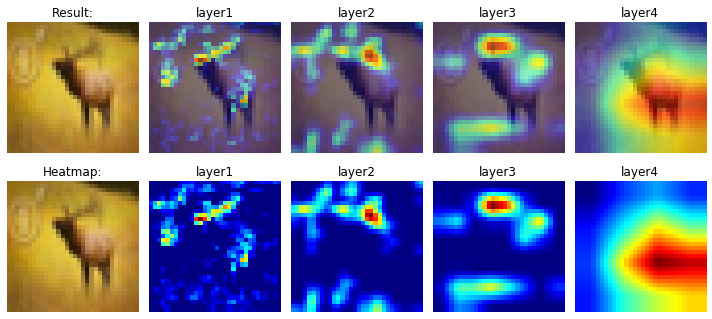

<Figure size 432x288 with 0 Axes>

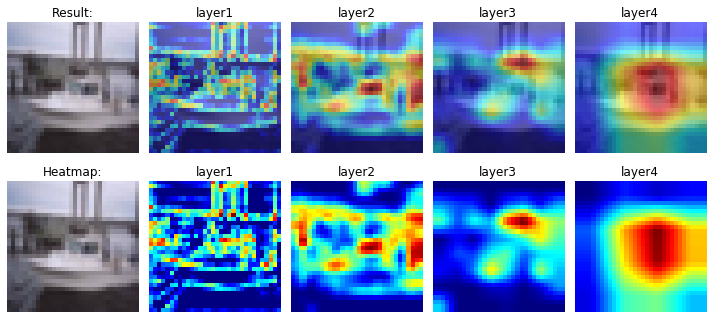

<Figure size 432x288 with 0 Axes>

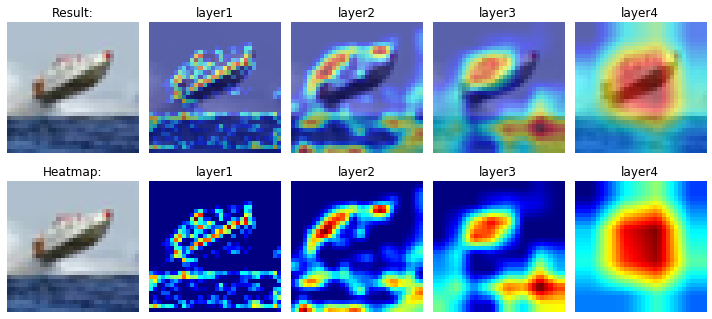

<Figure size 432x288 with 0 Axes>

In [0]:
plot_gradcam(gradcam_views, layers, 'grad_cam')

## Display Correct and Incorrect Predictions

In [0]:
# This cell will take some time to run

# Unnormalize correct samples
for idx in range(len(correct_samples)):
    correct_samples[idx]['image'] = dataset.unnormalize(correct_samples[idx]['image'], transpose=True)

# Unnormalize incorrect samples
for idx in range(len(incorrect_samples)):
    incorrect_samples[idx]['image'] = dataset.unnormalize(incorrect_samples[idx]['image'], transpose=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

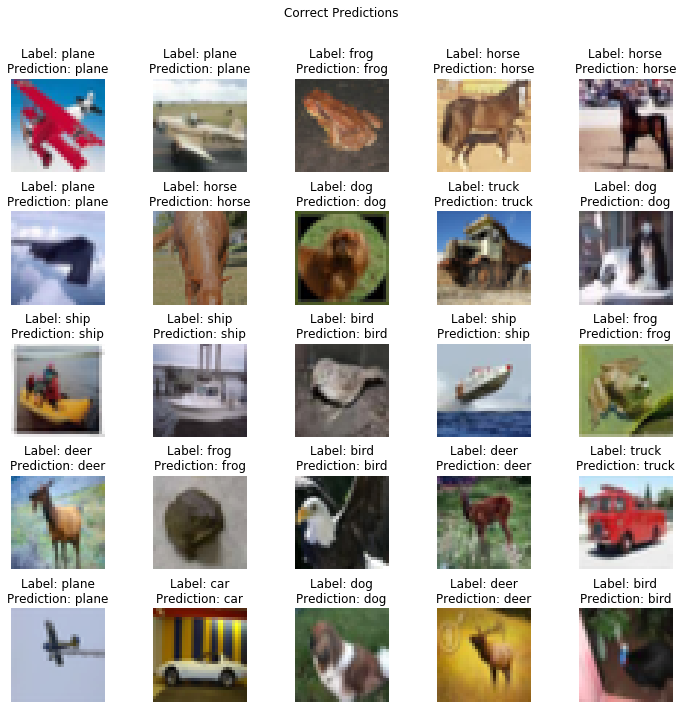

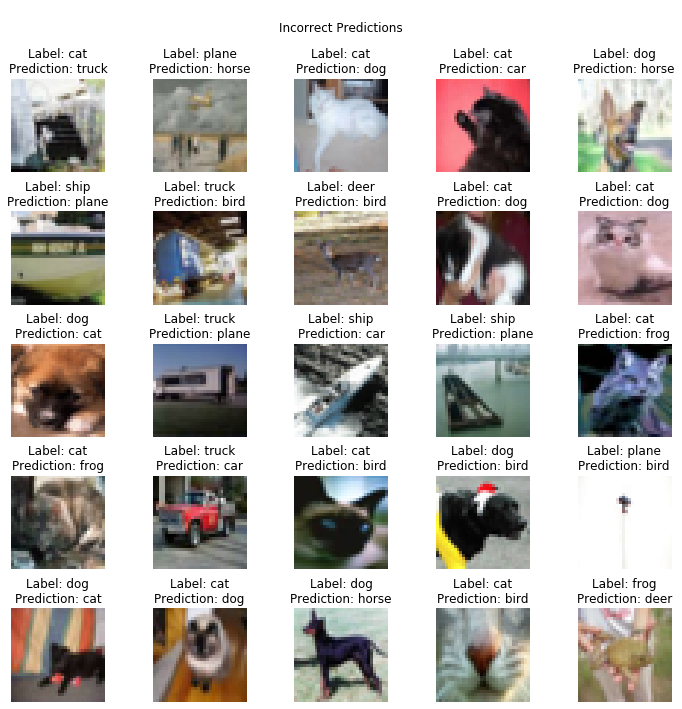

In [0]:
save_and_show_result(classes, correct_samples, incorrect_samples, path='predictions')

## Result Analysis

Displaying accuracy for each class in the entire validation dataset

In [0]:
class_level_accuracy(model, val_loader, device, classes)

Accuracy of plane : 93 %
Accuracy of   car : 96 %
Accuracy of  bird : 87 %
Accuracy of   cat : 79 %
Accuracy of  deer : 91 %
Accuracy of   dog : 85 %
Accuracy of  frog : 95 %
Accuracy of horse : 94 %
Accuracy of  ship : 94 %
Accuracy of truck : 94 %
